In [20]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score

In [7]:
!unzip fashion-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png  
  inflating: fashion-mnist/test/0/645.png  
  inflating: fashion-mnist/test/0/34.png  
  inflating: fashion-mnist/test/0/716.png  
  inflating: fashion-mnist/test/0/3874.png  
  inflating: fashion-mnist/test/0/3128.png  
  inflating: fashion-mnist/test/0/2180.png  
  inflating: fashion-mnist/test/0/2439.png  
  inflating: fashion-mnist/test/0/269.png  
  inflating: fashion-mnist/test/0/2027.png  
  inflating:

In [8]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/8/45081.png'

In [9]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(55000, 10000, 5000)

In [10]:
#--- Cargamos los datos de entrenamiento en listas


N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

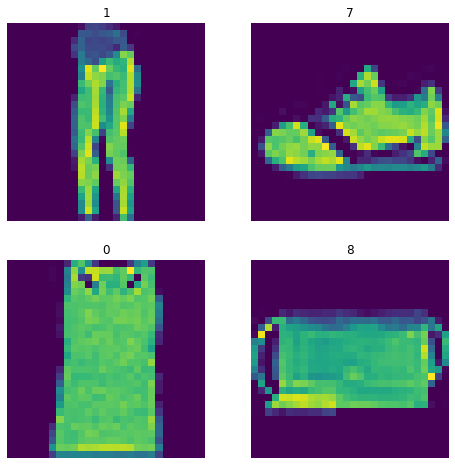

In [11]:

#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [12]:
#--- Convetimos las listas con los datos a tensores de torch
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [13]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [14]:
#--- Definimos la CNN

model = torch.nn.Sequential(
    #28*28
  torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
  # ( (28-3+[2*1])/1 ) + 1 = 28   -> 28*28*16

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 28/2 = 14                 -> 14*14*16

  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(16, 32, kernel_size=4, stride=1, padding=3),
  # ( (14-4+[2*3])/1 ) + 1 = 16   -> 16*16*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 16/2 = 8                 -> 8*8*32

  torch.nn.Dropout(p=0.1), 

  torch.nn.Flatten(),
  torch.nn.Linear(8*8*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.1, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=2048, out_features=10, bias=True)
)

In [15]:
#--- Definimos los criterios de evaluación y el optmizador

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

In [16]:
!pip install hiddenlayer


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


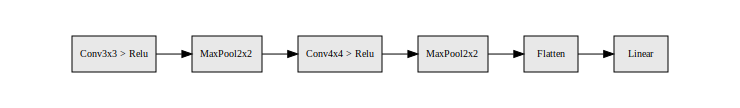

In [17]:
import hiddenlayer as hl

hl.build_graph(model, torch.zeros([32,1,28,28]))

In [18]:

#-- Después de activar el entorno GPU se selecciona el dispositivo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


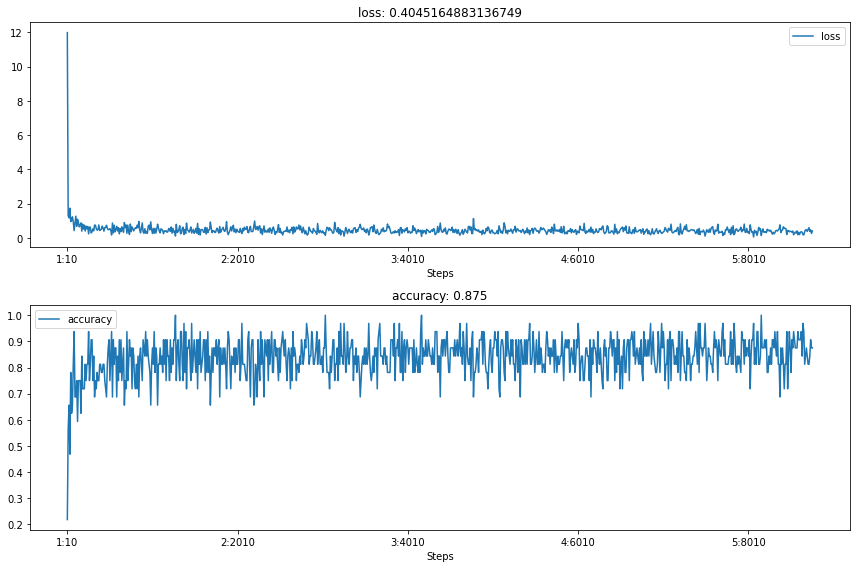

KeyboardInterrupt: ignored

In [21]:
#-- Cargamos el modelo en la GPU
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

n_epoch = 10

history2 = hl.History()
canvas2 = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        history2.log((epoch+1, iter), loss=loss, accuracy=acc)
        with canvas2:
          canvas2.draw_plot(history2["loss"])
          canvas2.draw_plot(history2["accuracy"])

In [22]:
#-- Validamos el modelo

X_valid, Y_valid = X_valid.to(device), Y_valid.to(device)
model.eval()
Xvl = X_valid.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_valid)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_valid.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_valid == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.37, F1:0.87, Acc:0.87


Mi red neuronal consiste de dos capas convolucionales, 2 lineas de max pooling, con droput del 0.2. <br>
La primera capa convolucional recive 28 $\cdot$ 28 $\cdot$ 1 caracteristicas y entrega 28 $\cdot$ 28 $\cdot$ 36 caracteristicas. Usando:

1.   Tamaño de salida de 16
2.   Kernel de 3
3.   Stride de 1
4.   Padding de 1

La segunda capa convolucional recive 14 $\cdot$ 14  $\cdot$ 16 cracteristicas y entrega 16  $\cdot$ 16  $\cdot$ 32 caracteristicas. Usando

1.  Tamaño de salida 32
2.  Kernel de 4
3.  Stride de 1
4.  Padding de 3

Vemos que la red nueronal tiene un problema para mantener una ACC consistente durante el entrenamiento. Lo que puede signifcar que se debería dismunir el dropout. Ya que esa varían tan fuerte en el Acc Y el Loss no es buena. También que creo que se esta sobre entrenando. Ya que cuando entra a la segunda epoca ya está totalmente entrenada y solamente salta entre los mismos valores de ACC y loss